#### Necessary imports

In [1]:
import os
import cv2
import rootutils
import numpy as np
from PIL import Image
from IPython.display import display

import torch
import torchvision.transforms as transforms

# adding root to python path
rootutils.setup_root(
    os.path.abspath(''), indicator=['.git', 'pyproject.toml'], pythonpath=True
)

from src.models.components.cnn_cam_multihead import CNNCAMMultihead
from src.models.components.vit_rollout_multihead import VitRolloutMultihead
from src.models.components.nn_utils import weight_load

#### Helper functions

In [2]:
def apply_cm(
    image: np.array, map: np.array, threshold: float = 0.5, alpha: float = 0.5
) -> np.array:
    """Apply color map on image

    Args:
        image (np.array): Image
        map (np.array): Grayscale, unnormalized cm.
        threshold (float, optional): Threshold for map. Defaults to 0.5.
        alpha (float, optional): Transparency. Defaults to 0.5.

    Returns:
        np.array: Image with applied cm.
    """
    map_thresholded = np.where(map > threshold, 1, 0)
    map_thresholded = (map_thresholded * 255).astype(np.uint8)
    map_thresholded = cv2.cvtColor(map_thresholded, cv2.COLOR_GRAY2RGB)

    map_normalized = cv2.normalize(
        map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U
    )
    map_colored = cv2.applyColorMap(map_normalized, cv2.COLORMAP_JET)
    blended_image = cv2.addWeighted(image, 1 - alpha, map_colored, alpha, 0)

    return blended_image

In [3]:
def display_img_with_map(out: torch.tensor, map: torch.tensor, image: np.array) -> None:
    """Displays image with explainability map.

    Args:
        out (torch.tensor): Neural network prediction.
        map (torch.tensor): Neural network explainability output.
        image (np.array): Original inference image.
    """
    preds = (out > 0.5).float()
    for i, pred in enumerate(preds):
        map_segmentation = map[i] if pred == 1 else torch.zeros_like(map[i])
        if pred == 1:
            map_segmentation = (map_segmentation - map_segmentation.min()) / (
                map_segmentation.max() - map_segmentation.min()
            )
        map_segmentation = map_segmentation.cpu().numpy()
        blended_img = apply_cm(image, map_segmentation)

        # Only for displaying
        blended_img = cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(blended_img))

#### Load sample images

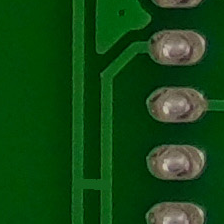

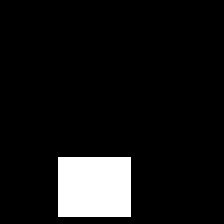

In [4]:
image = cv2.imread('../docs/sample_data/01_short_04_1926_1070.png', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(image))
label = cv2.imread(
    '../docs/sample_data/01_short_04_1926_1070_label.png', cv2.IMREAD_GRAYSCALE
)
display(Image.fromarray(label))

#### Device setup

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Transforms

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0).to(device)

#### CNN with cam output

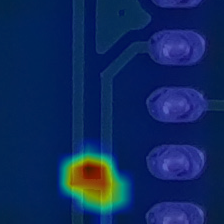

In [8]:
cnn_model = CNNCAMMultihead(
    backbone='torchvision.models/efficientnet_v2_s',
    return_node='features.6.0.block.0',
    multi_head=True,
).to(device)
weights = weight_load(
    ckpt_path='../trained_models/models--DeepVisionXplain--efficientnet_v2_s_downscaled_pcb/',
    weights_only=True,
)
cnn_model.load_state_dict(weights)
cnn_model.eval()

with torch.no_grad():
    out, map = cnn_model(image_tensor)
display_img_with_map(out, map, image)

#### ViT with attention rollout output

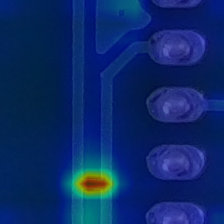

In [9]:
vit_model = VitRolloutMultihead(
    backbone='timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k', multi_head=True
).to(device)
weights = weight_load(
    ckpt_path='../trained_models/models--DeepVisionXplain--vit_tiny_patch16_224.augreg_in21k_ft_in1k_pcb/',
    weights_only=True,
)
vit_model.load_state_dict(weights)
vit_model.eval()

with torch.no_grad():
    out, map = vit_model(image_tensor)
display_img_with_map(out, map, image)